# *(Sherman & Rinzel, 1992)* Gap junction leads to anti-synchronization

Implementation of the paper: 

- *Sherman, A., & Rinzel, J. (1992). Rhythmogenic effects of weak electrotonic coupling in neuronal models. Proceedings of the National Academy of Sciences, 89(6), 2471-2474.*

Author: [Chaoming Wang](https://github.com/chaoming0625)

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [2]:
import matplotlib.pyplot as plt

## Fig 1: weakly coupled cells can oscillate antiphase

The "square-wave burster" model is given by:

$$
\begin{split}
\tau {dV \over dt} &= -I_{in}(V) - I_{out}(V) - g_s S (V-V_K) + I + I_j \\
\tau {dn \over dt} &= \lambda (n_{\infty} - n)
\end{split}
$$

where 

$$
\begin{split}
I_{in}(V) &= g_{Ca} m (V-V_{Ca}) \\
I_{out}(V) &= g_Kn(V-V_K) \\
m &= m_{\infty}(V) \\
x_{\infty} (V) &= {1 \over 1 + \exp[(V_x - V) / \theta_x]} \\
I_j &= -g_c (V-\bar{V})
\end{split}
$$

where 

$$
\begin{split}
S &= 0.15 \\
\lambda &= 0.8 \\
V_m &= -20 \\
\theta_m &= 12 \\
V_n &= -17 \\
\theta_n &= 5.6 \\
V_{Ca} &= 25 \\
V_{K} &= -75 \\
\tau &= 20 \, \mathrm{ms} \\
g_{Ca} &= 3.6 \\
g_K &= 10 \\
g_s &= 4
\end{split}
$$

At t = 0.5 s the junctional-coupling conductance, $g_c$, is raised to 0.08, and a small symmetry-breaking perturbation (0.3 mV) is applied to one of the
cells. This destabilizes the single-cell oscillation and leads to an
antiphase oscillation. At t = 5.5 s the single-cell behavior is restored
by increasing $g_c$ to 0.24; alternatively, one could set $g_c$ to 0, but then
the two cells would not be in-phase.

In [3]:
lambda_ = 0.8
V_m = -20
theta_m = 12
V_n = -17
theta_n = 5.6
V_ca = 25
V_K = -75
tau = 20
g_ca = 3.6
g_K = 10
g_s = 4

In [4]:
class Model1(bp.dyn.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(Model1, self).__init__()

    # parameters
    self.gc = bm.Variable(bm.zeros(1))
    self.I = bm.Variable(bm.zeros(2))
    self.S = 0.15

    # variables
    self.V = bm.Variable(bm.zeros(2))
    self.n = bm.Variable(bm.zeros(2))

    # integral
    self.integral = bp.odeint(bp.JointEq([self.dV, self.dn]), method=method)

  def dV(self, V, t, n):
    I_in = g_ca / (1 + bp.math.exp((V_m - V) / theta_m)) * (V - V_ca)
    I_out = g_K * n * (V - V_K)
    Is = g_s * self.S * (V - V_K)
    Ij = self.gc * bm.array([V[0] - V[1], V[1] - V[0]])
    dV = (- I_in - I_out - Is - Ij + self.I) / tau
    return dV

  def dn(self, n, t, V):
    n_inf = 1 / (1 + bp.math.exp((V_n - V) / theta_n))
    dn = lambda_ * (n_inf - n) / tau
    return dn

  def update(self, _t, _dt):
    V, n = self.integral(self.V, self.n, _t, _dt)
    self.V.value = V
    self.n.value = n

In [5]:
def run_and_plot1(model, duration, inputs=None, plot_duration=None):
  runner = bp.dyn.DSRunner(model, inputs=inputs, monitors=['V', 'n', 'gc', 'I'])
  runner.run(duration)

  fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
  plot_duration = (0, duration) if plot_duration is None else plot_duration

  fig.add_subplot(gs[0:3, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.ylabel('V [mV]')
  plt.xlim(*plot_duration)

  fig.add_subplot(gs[3, 0])
  plt.plot(runner.mon.ts, runner.mon.gc)
  plt.ylabel(r'$g_c$')
  plt.xlim(*plot_duration)

  fig.add_subplot(gs[4, 0])
  plt.plot(runner.mon.ts, runner.mon.I[:, 0])
  plt.ylabel(r'$I_0$')
  plt.xlim(*plot_duration)

  plt.xlabel('Time [ms]')
  plt.show()

In [6]:
model = Model1()
model.S = 0.15
model.V[:] = -55.
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))

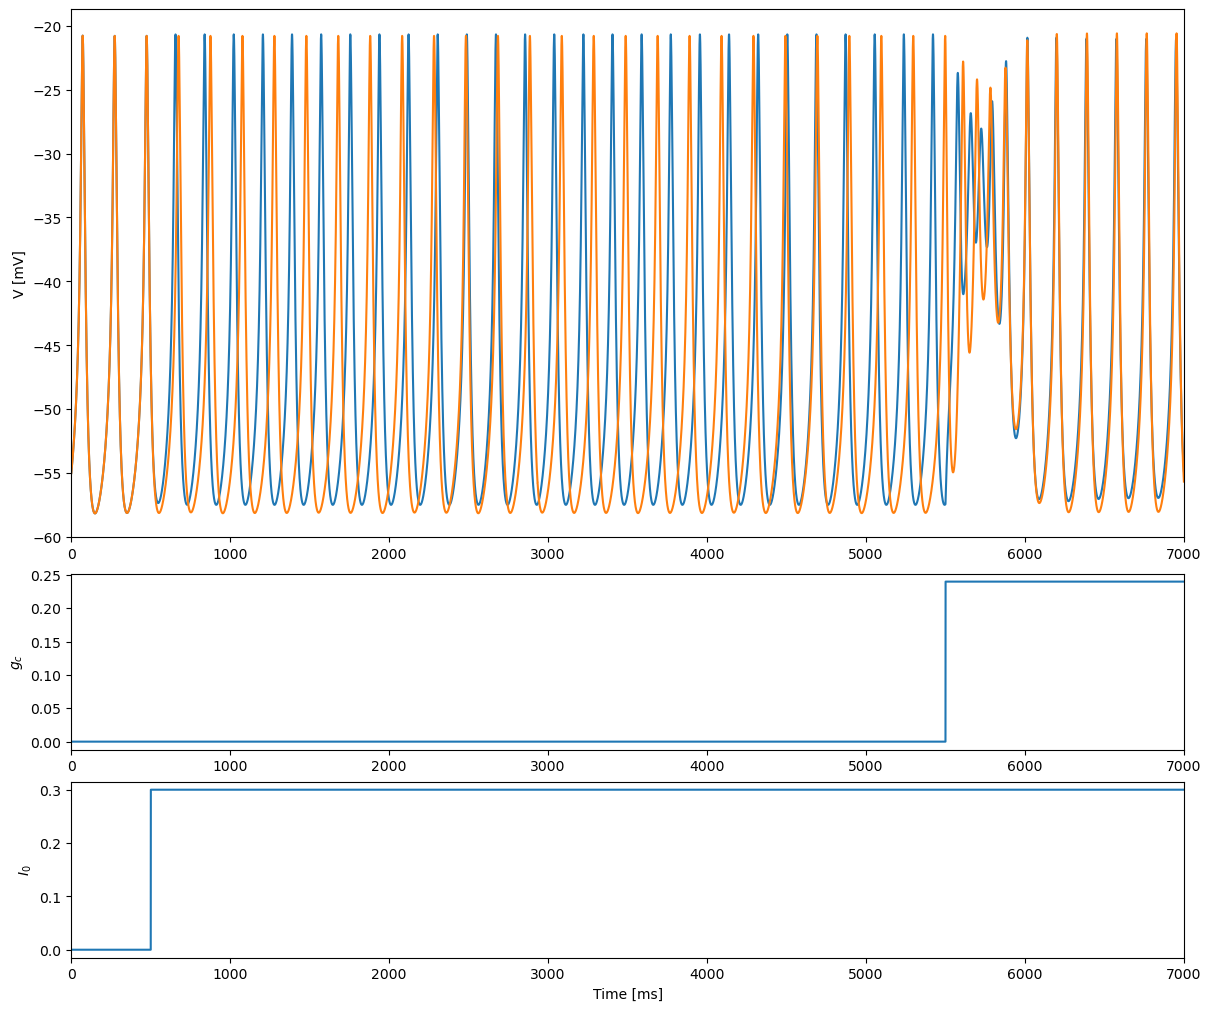

In [7]:
gc = bp.inputs.section_input(values=[0., 0.0, 0.24], durations=[500, 5000, 1500])
Is = bp.inputs.section_input(values=[0., bm.array([0.3, 0.])], durations=[500., 6500.])
run_and_plot1(model, duration=7000, inputs=[('gc', gc, 'iter', '='),
                                            ('I', Is, 'iter', '=')])

## Fig 2: weak coupling can convert excitable cells into spikers

Cells are initially uncoupled and at rest, but one cell has a current of strength 1.0 injected for 0.5 s, resulting in two
spikes. Spiking ends when the current stimulus is removed. The
unstimulated cell remains at rest. At t = 2 s, $g_c$ is
increased to 0.04. This does not prevent the stimulated cell from
remaining at rest, but the system is now bistable and the rest state
coexists with an antiphase oscillation. A second identical current
stimulus draws both cells near enough to the oscillatory solution so
that they continue to oscillate after the stimulus terminates.

In [8]:
model = Model1()
model.S = 0.177
model.V[:] = -62.69
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))

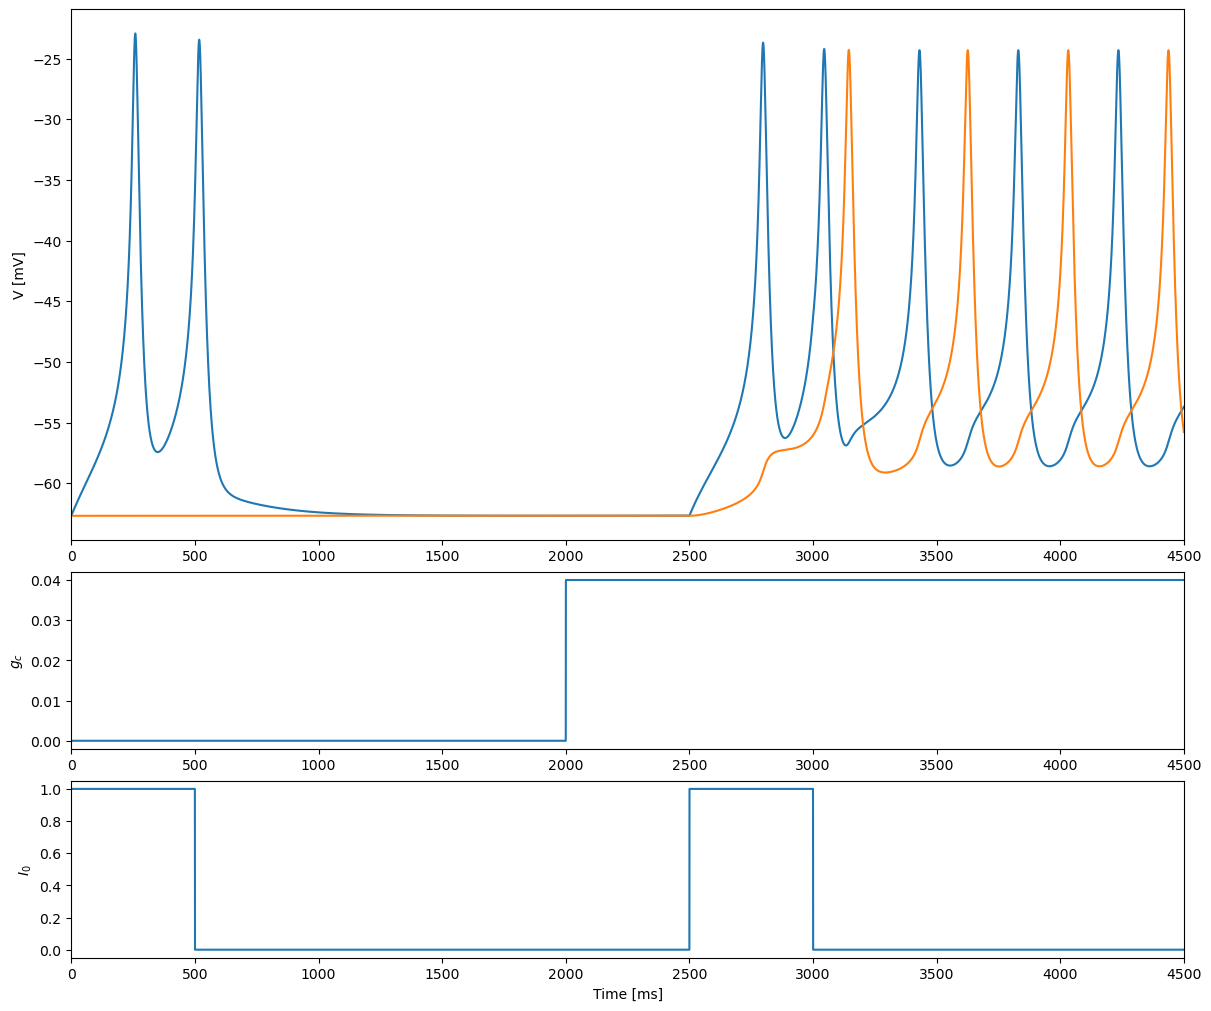

In [9]:
gc = bp.inputs.section_input(values=[0, 0.04], durations=[2000, 2500])
Is = bp.inputs.section_input(values=[bm.array([1., 0.]), 0., bm.array([1., 0.]), 0.],
                             durations=[500, 2000, 500, 1500])

run_and_plot1(model, 4500, inputs=[('gc', gc, 'iter', '='),
                                   ('I', Is, 'iter', '=')])

## Fig 3: weak coupling can increase the period of bursting

We consider cells with endogenous bursting properties.
Now $S$ is a slow dynamic variable, satisfying

$$
\tau_S {dS \over dt} = S_{\infty}(V) - S
$$

with $\tau_S \gg \tau$.

In [10]:
tau_S = 35 * 1e3  # ms
V_S = -38  # mV
theta_S = 10  # mV

In [11]:
class Model2(bp.dyn.DynamicalSystem):
  def __init__(self, method='exp_auto'):
    super(Model2, self).__init__()

    # parameters
    self.lambda_ = 0.1
    self.gc = bm.Variable(bm.zeros(1))
    self.I = bm.Variable(bm.zeros(2))

    # variables
    self.V = bm.Variable(bm.zeros(2))
    self.n = bm.Variable(bm.zeros(2))
    self.S = bm.Variable(bm.zeros(2))

    # integral
    self.integral = bp.odeint(bp.JointEq([self.dV, self.dn, self.dS]), method=method)

  def dV(self, V, t, n, S):
    I_in = g_ca / (1 + bm.exp((V_m - V) / theta_m)) * (V - V_ca)
    I_out = g_K * n * (V - V_K)
    Is = g_s * S * (V - V_K)
    Ij = self.gc * bm.array([V[0] - V[1], V[1] - V[0]])
    dV = (- I_in - I_out - Is - Ij + self.I) / tau
    return dV

  def dn(self, n, t, V):
    n_inf = 1 / (1 + bm.exp((V_n - V) / theta_n))
    dn = self.lambda_ * (n_inf - n) / tau
    return dn

  def dS(self, S, t, V):
    S_inf = 1 / (1 + bm.exp((V_S - V) / theta_S))
    dS = (S_inf - S) / tau_S
    return dS

  def update(self, _t, _dt):
    V, n, S = self.integral(self.V, self.n, self.S, _t, dt=_dt)
    self.V.value = V
    self.n.value = n
    self.S.value = S

In [12]:
def run_and_plot2(model, duration, inputs=None, plot_duration=None):
  runner = bp.dyn.DSRunner(model, inputs=inputs, monitors=['V', 'S'])
  runner.run(duration)

  fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
  plot_duration = (0, duration) if plot_duration is None else plot_duration

  fig.add_subplot(gs[0:3, 0])
  plt.plot(runner.mon.ts, runner.mon.V)
  plt.ylabel('V [mV]')
  plt.xlim(*plot_duration)

  fig.add_subplot(gs[3:, 0])
  plt.plot(runner.mon.ts, runner.mon.S)
  plt.ylabel('S')
  plt.xlim(*plot_duration)

  plt.xlabel('Time [ms]')
  plt.show()

With $\lambda = 0.9$, an isolated cell alternates periodically between a
depolarized spiking phase and a hyperpolarized silent phase.

In [13]:
model = Model2()
model.lambda_ = 0.9
model.S[:] = 0.172
model.V[:] = V_S - theta_S * bm.log(1 / model.S - 1)
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))
model.gc[:] = 0.
model.I[:] = 0.

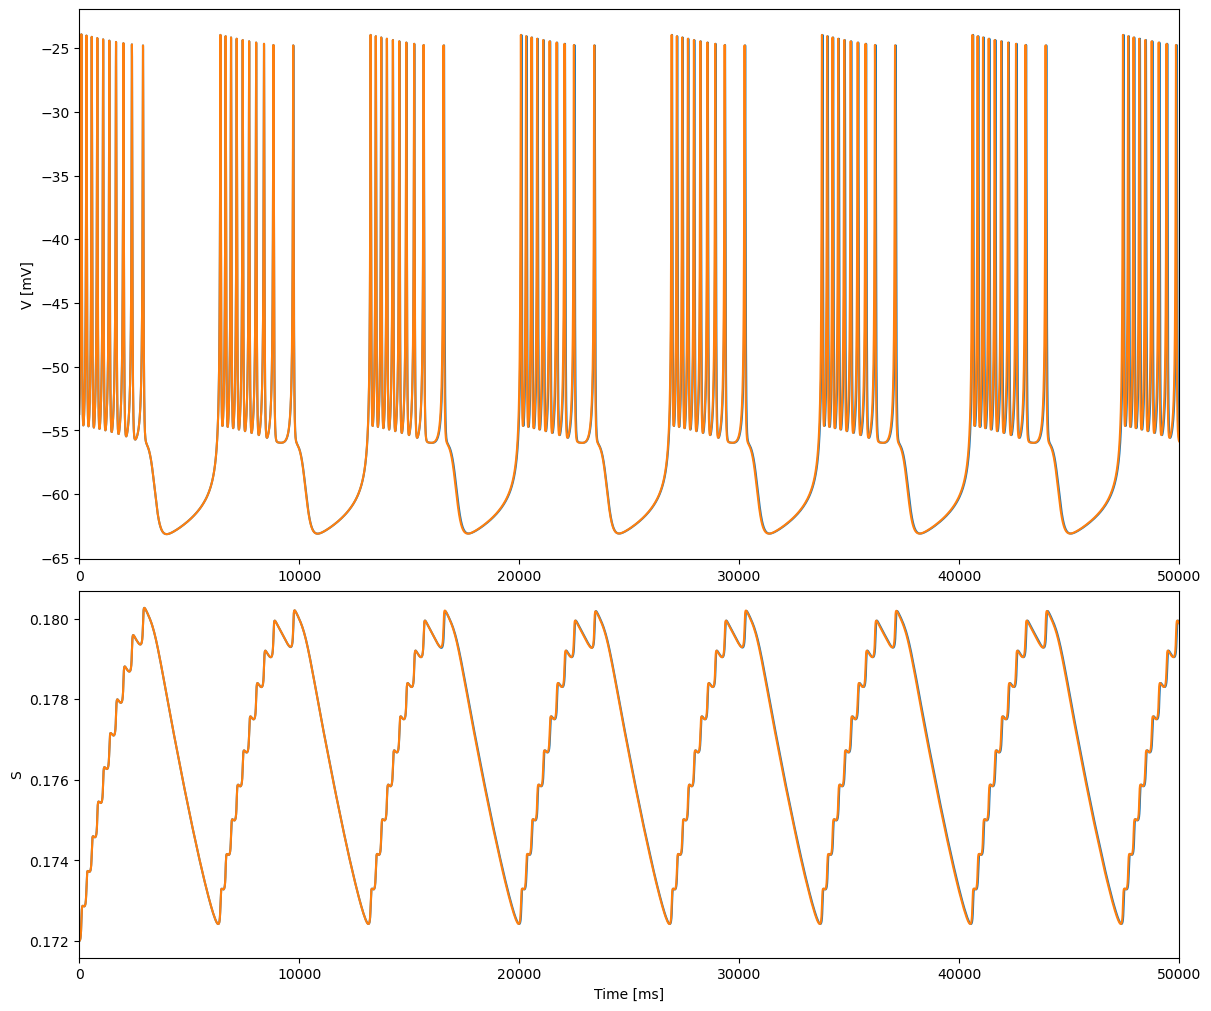

In [14]:
run_and_plot2(model, 50 * 1e3)

When two identical bursters are coupled with $g_c = 0.06$ and
started in-phase, they initially follow the single-cell bursting
solution. This behavior is unstable, however, and a
new stable burst pattern emerges during the second burst
with smaller amplitude, higher frequency, antiphase spikes.

In [15]:
model = Model2(method='exp_auto')
model.lambda_ = 0.9
model.S[:] = 0.172
model.V[:] = V_S - theta_S * bm.log(1 / model.S - 1)
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))
model.gc[:] = 0.06
model.I[:] = 0.

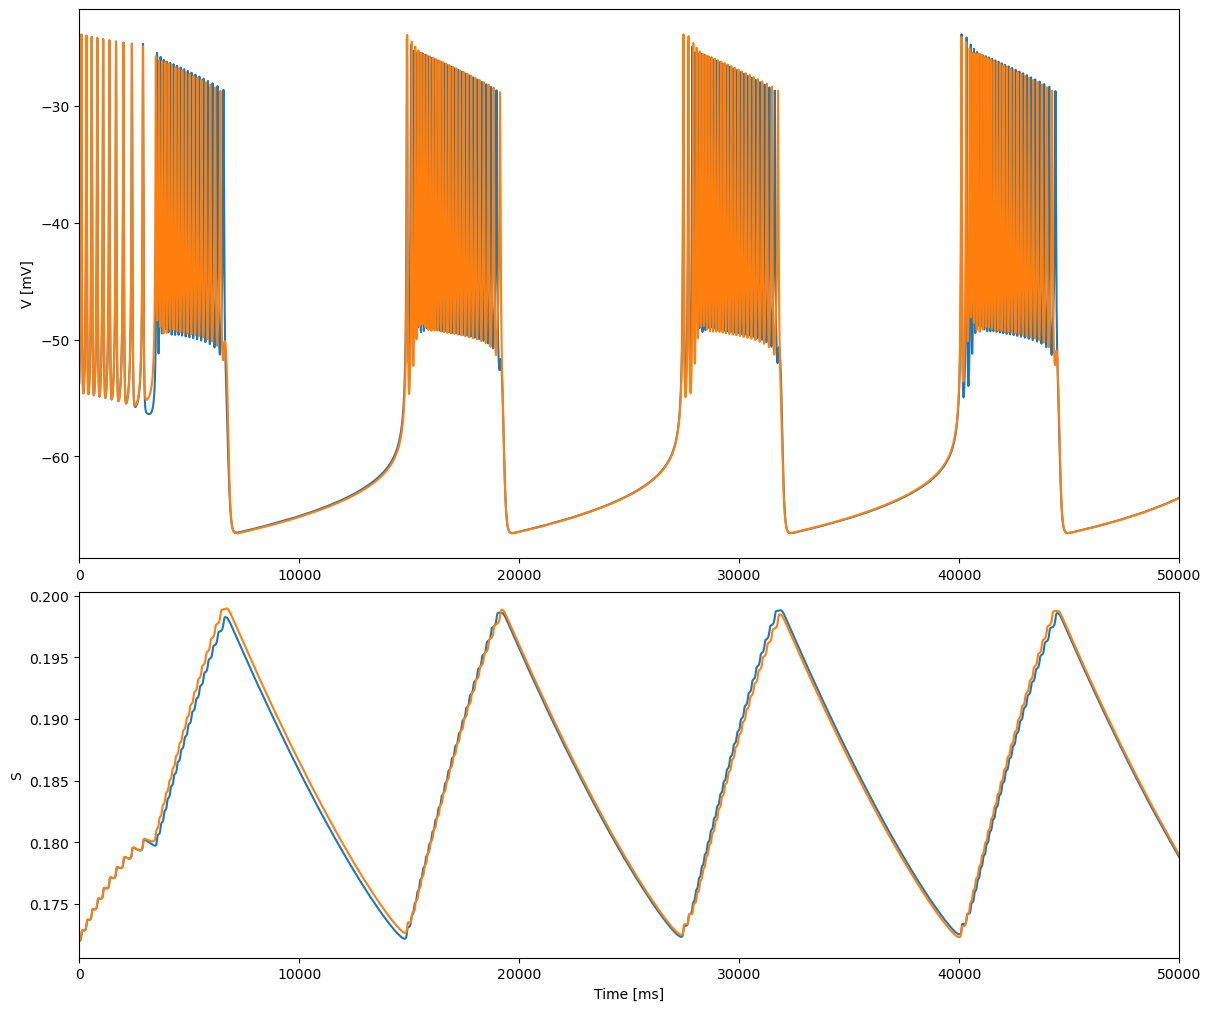

In [16]:
run_and_plot2(model, 50 * 1e3)

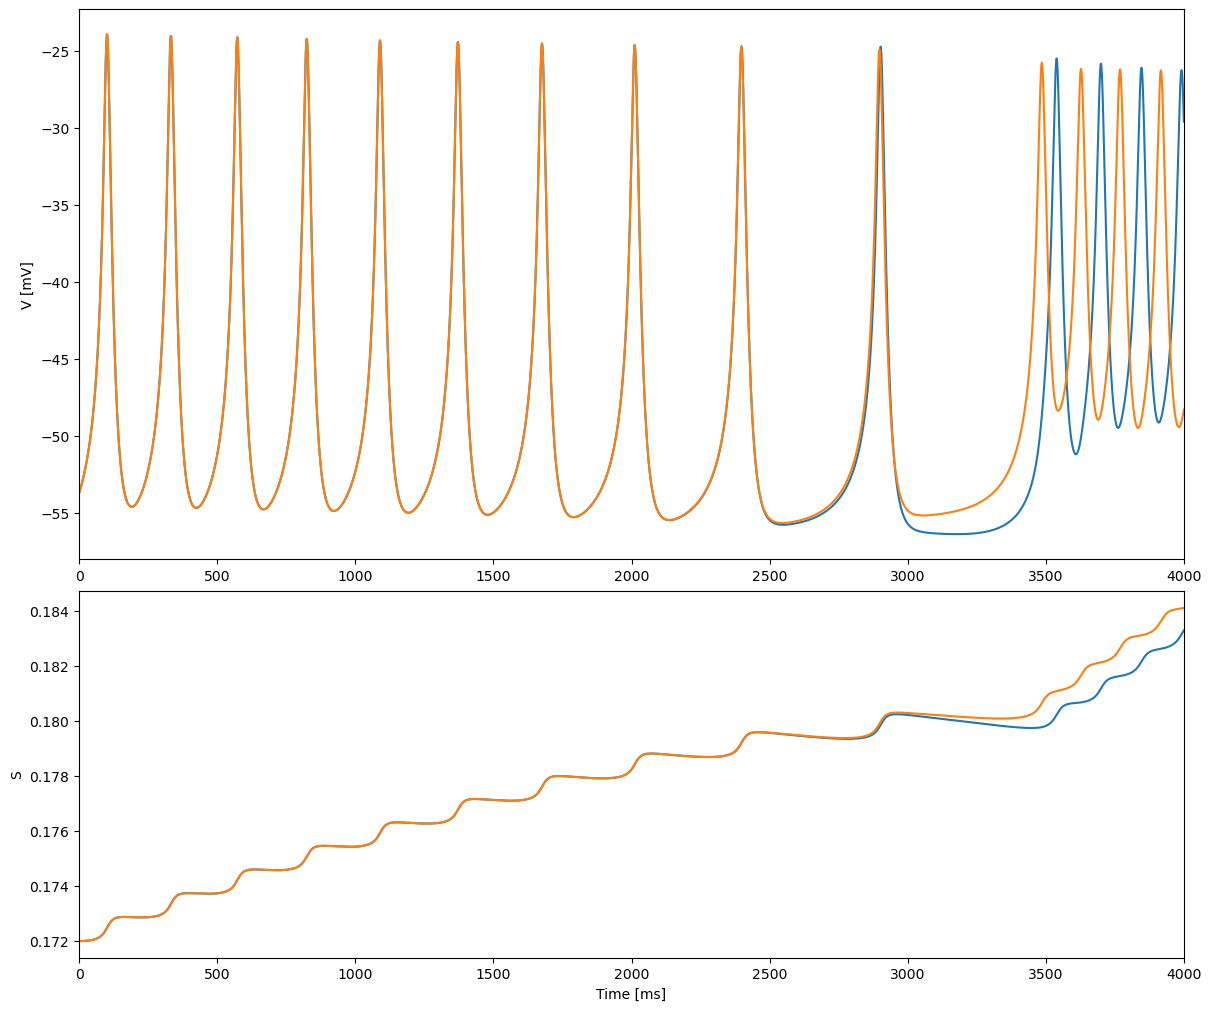

In [17]:
model = Model2(method='exp_auto')
model.lambda_ = 0.9
model.S[:] = 0.172
model.V[:] = V_S - theta_S * bm.log(1 / model.S - 1)
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))
model.gc[:] = 0.06
model.I[:] = 0.
run_and_plot2(model, 4 * 1e3)

## Fig 4: weak coupling can convert spikers to bursters

Parameters are the same as in Fig. 3, except $\lambda = 0.8$, resulting in repetitive spiking (beating) instead of bursting. Oscillations in $S$ are nearly abolished. Two identical cells are started with identical initial conditions (only one shown for clarity). At t = 20 s, $g_c$ is increased to
0.04 (right arrow) and a small symmetry-breaking perturbation (0.3
mV) is applied to one cell. After a brief transient, the two cells begin
to burst in-phase but with antiphase spikes, as in Fig. 3.

In [18]:
model = Model2()
model.lambda_ = 0.8
model.S[:] = 0.172
model.V[:] = V_S - theta_S * bm.log(1 / model.S - 1)
model.n[:] = 1 / (1 + bm.exp((V_n - model.V) / theta_n))
model.gc[:] = 0.06
model.I[:] = 0.

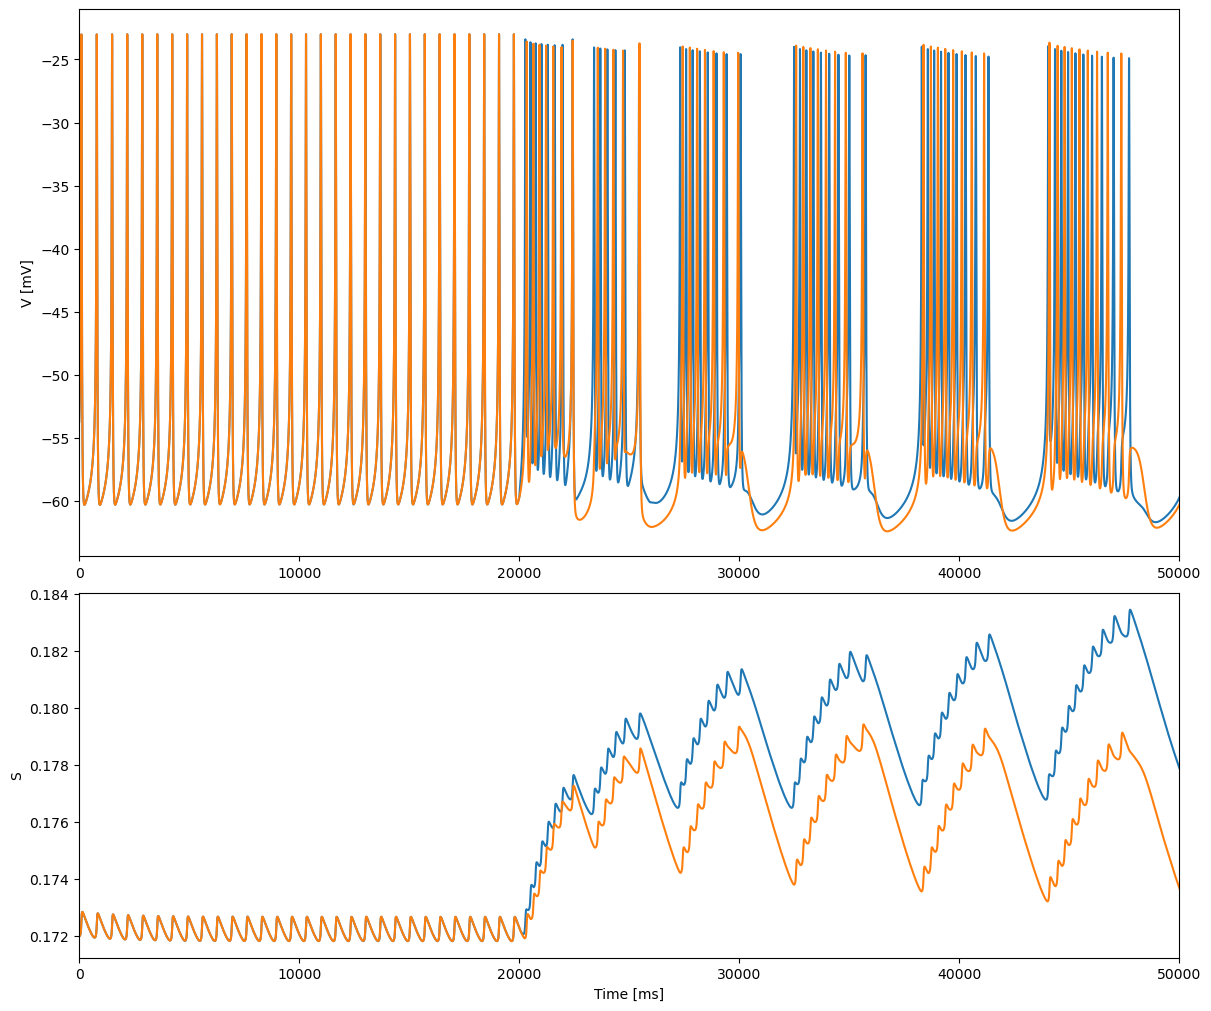

In [19]:
gc = bp.inputs.section_input(values=[0., 0.04], durations=[20 * 1e3, 30 * 1e3])
Is = bp.inputs.section_input(values=[0., bp.math.array([0.3, 0.])], durations=[20 * 1e3, 30 * 1e3])
run_and_plot2(model, 50 * 1e3, inputs=[('gc', gc, 'iter', '='),
                                       ('I', Is, 'iter', '=')])